## Run Chunking Tests

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from tqdm.notebook import tqdm
from glob import glob
from matplotlib import pyplot as plt

import Regressions as reg
import DataBuild as db

plt.rcParams.update({'font.size': 25})

No w2v was able to load


In [2]:
def get_after_slow_probs(subject, **kwargs):
    """ Returns probability of each slow-fast pair following a slow 
        recall for a single subject.
    """
    # get model residuals in form of a generator
    # this will be used to populate a 2d df later
    model = reg.get_model(subject=subject, **kwargs)
    r_gen = (x for x in model.resid)
    # create a 2d mask for recs with True only where there is a recall counted in the model
    data = db.load_detailed_data(subject=subject)
    rec_mask = data['irt'] # going to filter for where there is a valid irt
    lag_keys = [k for k in data.keys() # also filter for where there is valid lags
                    if 'irt-' in k]
    rec_mask[~rec_mask.isnull()] = 1
    rec_mask[rec_mask.isnull()] = 0
    for lag in lag_keys:
        rec_mask[data[lag].isnull()] = 0
    rec_mask = rec_mask.astype(bool)
    # populate our rec_mask with the residuals from model
    for i, row in rec_mask.iterrows():
        for j, item in row.iteritems():
            if item:
                rec_mask.loc[i, j] = next(r_gen)
    rec_mask[rec_mask==False] = np.nan # flip from bools to floats
    # label model predictions as fast (F) and slow (S)
    f_mask = rec_mask<0
    s_mask = rec_mask>=0
    rec_mask[f_mask] = 'F'
    rec_mask[s_mask] = 'S'
    # get all groups of three recalls in terms of F and S
    threes = []
    for i, row in rec_mask.iterrows():
        recs = row[~row.isnull()]
        for j in recs.index[:-2]:
            threes.append(''.join(recs.loc[j:j+2]))
    # get probabilities of each pair-option after a slow
    slow_starts = np.asarray([i[1:] for i in threes if i[0] == 'S'])
    opts = ['FF', 'SS', 'FS', 'SF']
    probs = [slow_starts[slow_starts==opt].size/slow_starts.size for opt in opts]
    res = pd.Series(probs, index=opts, name=subject)
    # thats our subject result
    return res

In [3]:
def get_summary(**kwargs):
    """Returns summary chunking statistics for all subjects"""
    # get subject list
    subjs = db.get_subjs()
    # collect subject-level data
    data = []
    for subj in tqdm(subjs):
        data.append(get_after_slow_probs(subject=subj, **kwargs))
    # concatenate and summarize
    all_data = pd.concat(data, axis=1).transpose()
    summary = pd.DataFrame([all_data.mean(), 1.96*all_data.sem()], 
                 index=['mean', 'CI'],
                ).transpose()
    summary['N'] = all_data.shape[0]
    return summary

In [7]:
# PLOT CHUNKING BARS
def plot_chunking(summary_data, axes=None, show_ticks=True):
    """Models IRTs for all subjects and computes and graphs chunking stats."""
    
    if axes is None:
        fig, axes = plt.subplots(figsize=(7,9))

    axes.bar(summary_data.index, summary_data['mean'],
            edgecolor='k', color='w', linewidth=2)
    axes.errorbar(summary_data.index, summary_data['mean'],
                 summary_data['CI'], color='k', linestyle='',
                 capsize=7, linewidth=3
                )

    # line at expected from chance value
    axes.axhline(.25, color='grey', linestyle='--')

    axes.set_ylim((.19,.36))
    
    if show_ticks:
        axes.set_yticks((.2,.25,.3, .35), fontsize=20)
        axes.set_ylabel('Probability Following a Slow Response')
    else:
        axes.set_yticks(())

In [5]:
basemodel = get_summary(model_num=1)
fullmodel = get_summary()

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

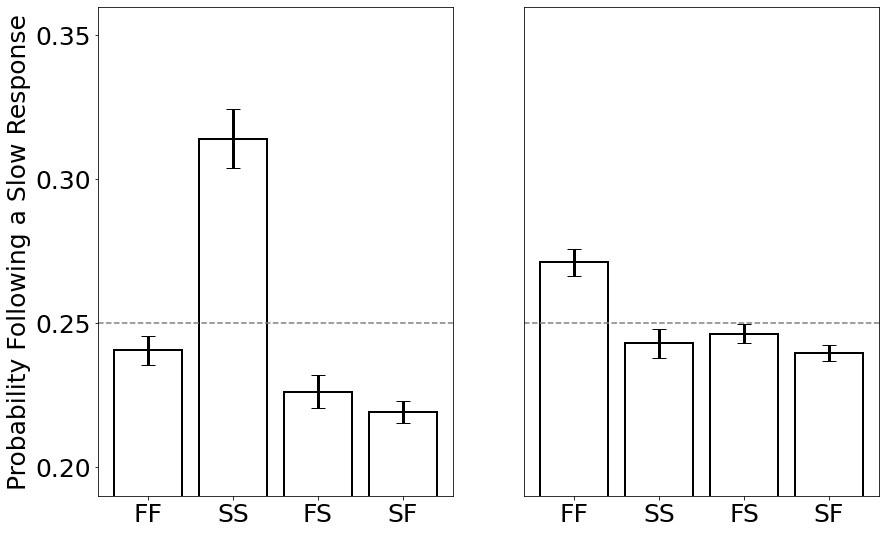

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(14,9))
plot_chunking(basemodel, axes[0])
plot_chunking(fullmodel, axes[1], show_ticks=False)